In [3]:
# General imports 
import os
import numpy as np
import glob

import bruker2cil as bc

### Import all CIL components needed
from cil.framework import ImageData, ImageGeometry
from cil.plugins import tigre
from cil.io import TIFFWriter, TIFFStackReader
from cil.processors import CentreOfRotationCorrector, Binner, TransmissionAbsorptionConverter,RingRemover
from cil.recon import FDK
from cil.utilities.display import show2D, show_geometry


In [4]:
# Set variables and paths

datadir = './samples/02-switch-large'
dataset_prefix = '001_'
infofile = os.path.join(datadir,dataset_prefix+'.info')
logfile = os.path.join(datadir,dataset_prefix+'.log')

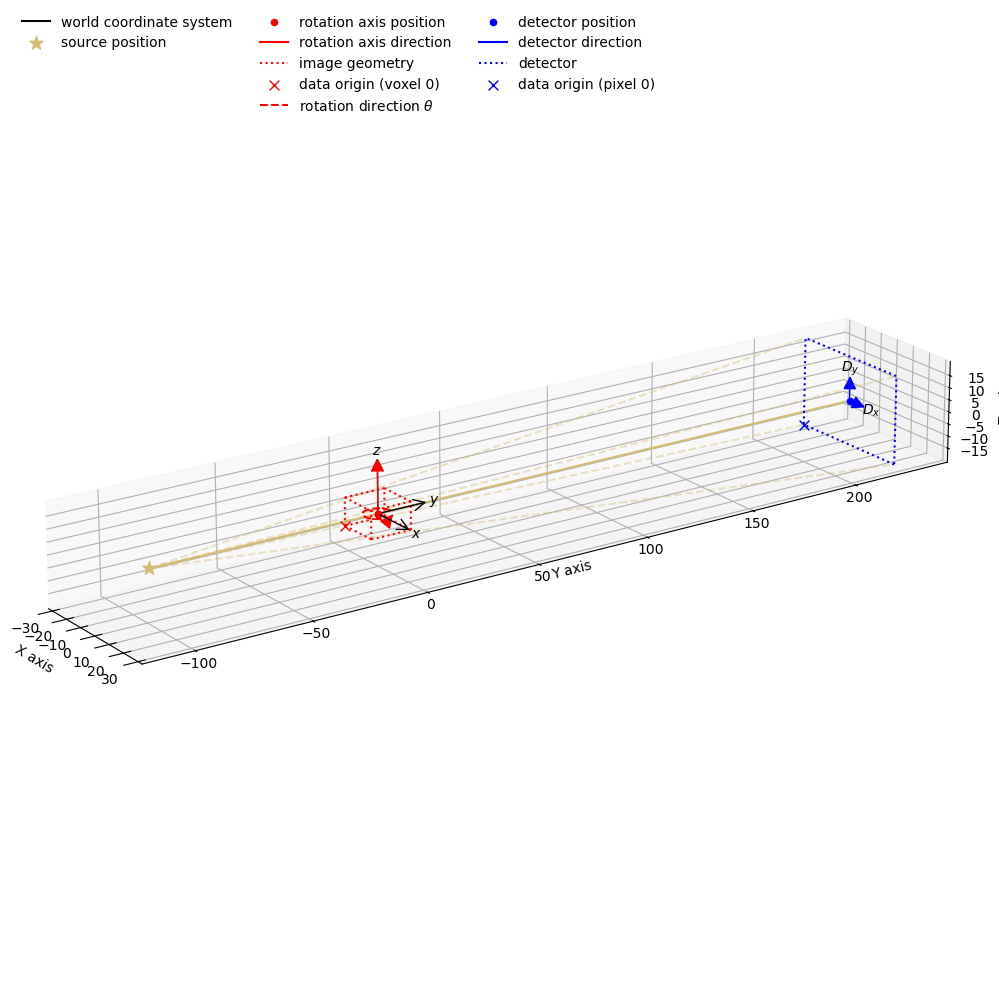

In [20]:
ag = bc.set_geometry(infofile,logfile)
show_geometry(ag,grid=True,view_distance=10,azimuthal=-35)

In [21]:
filelist = bc.get_filelist(datadir,dataset_prefix)
#print(filelist)
if len(ag.angles) != len(filelist):
    print('Warning: Number of files does not correspond to number of rotational steps!')

In [22]:
# Modify ROI and data binning if needed
bin = (1,1,1)
roi={'axis_0': (0,ag.num_projections,bin[0]), # angle
     'axis_1': (0,ag.pixel_num_v,bin[1]), # height
     'axis_2': (0,ag.pixel_num_h,bin[2]) # width
    } 

# Create CIL reader
reader = TIFFStackReader(file_name=filelist,roi=roi)


In [23]:
proj = reader.read_as_AcquisitionData(ag)

In [24]:
proj.shape

(451, 486, 764)

In [25]:
# Optional: Apply Centre of Rotation Corrector

processor = CentreOfRotationCorrector.image_sharpness('centre', 'tigre') 
processor.set_input(proj) 
processor.get_output(out=proj)

In [26]:
# Optional data binning

#roi = {'horizontal':(None,None,4),'vertical':(None,None,4)}
#processor = Binner(roi)
#processor.set_input(proj)
#proj = processor.get_output()


In [27]:
# Optional: Ring artefact removal

#processor = RingRemover(decNum=4, wname='db10', sigma=1.5, info=True)
#processor.set_input(proj)
#proj = processor.get_output()

In [28]:
# Substract Background
background = proj.get_slice(vertical=20, force=True).mean()
proj /= background

In [29]:
# Prepare data for reconstruction

proj = TransmissionAbsorptionConverter(min_intensity=0.000001)(proj)
proj.reorder(order='tigre')
ig = proj.geometry.get_ImageGeometry()


In [30]:
print('Acquisition geometry:\n',ag,end='\n\n')
print('Projection geometry:\n',proj,end='\n\n')
print('Image geometry:\n',ig)

Acquisition geometry:
 3D Cone-beam tomography
System configuration:
	Source position: [  0.   , -98.706,   0.   ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.   , 222.306,   0.   ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [764 486]
	Pixel size: [0.0748 0.0748]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 451
	Angles 0-9 in degrees: [0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2]
	Angles 441-450 in degrees: [352.8, 353.6, 354.4, 355.2, 356. , 356.8, 357.6, 358.4, 359.2, 360. ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance

Projection geometry:
 Number of dimensions: 3
Shape: (451, 486, 764)
Axis labels: ('angle', 'vertical', 'horizontal')


Image geometry:
 Number of channels: 1
channel_spacing: 1.0
voxel_num : x764,y764

-0.022757666 3.5046558


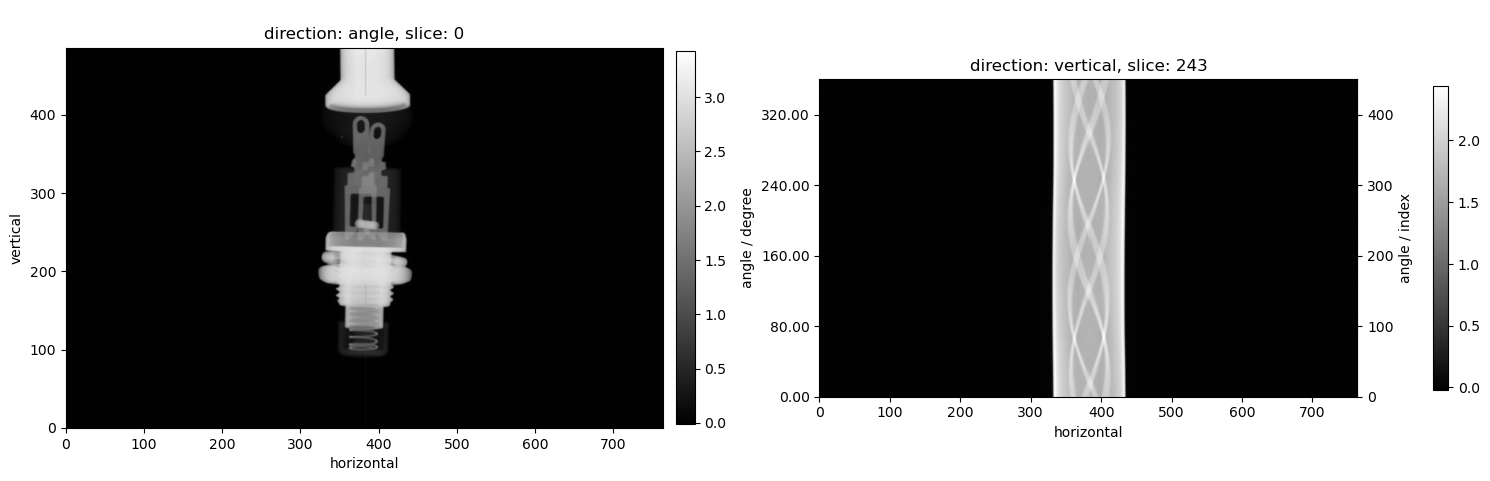

In [31]:
print(proj.min(), proj.max())
show2D(proj, slice_list=[('angle',0),('vertical', np.floor_divide(proj.shape[1],2))])

In [32]:
# Perform reconstruction

fdk =  FDK(proj, ig)
recon = fdk.run()

FDK recon

Input Data:
	angle: 451
	vertical: 486
	horizontal: 764

Reconstruction Volume:
	vertical: 486
	horizontal_y: 764
	horizontal_x: 764

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



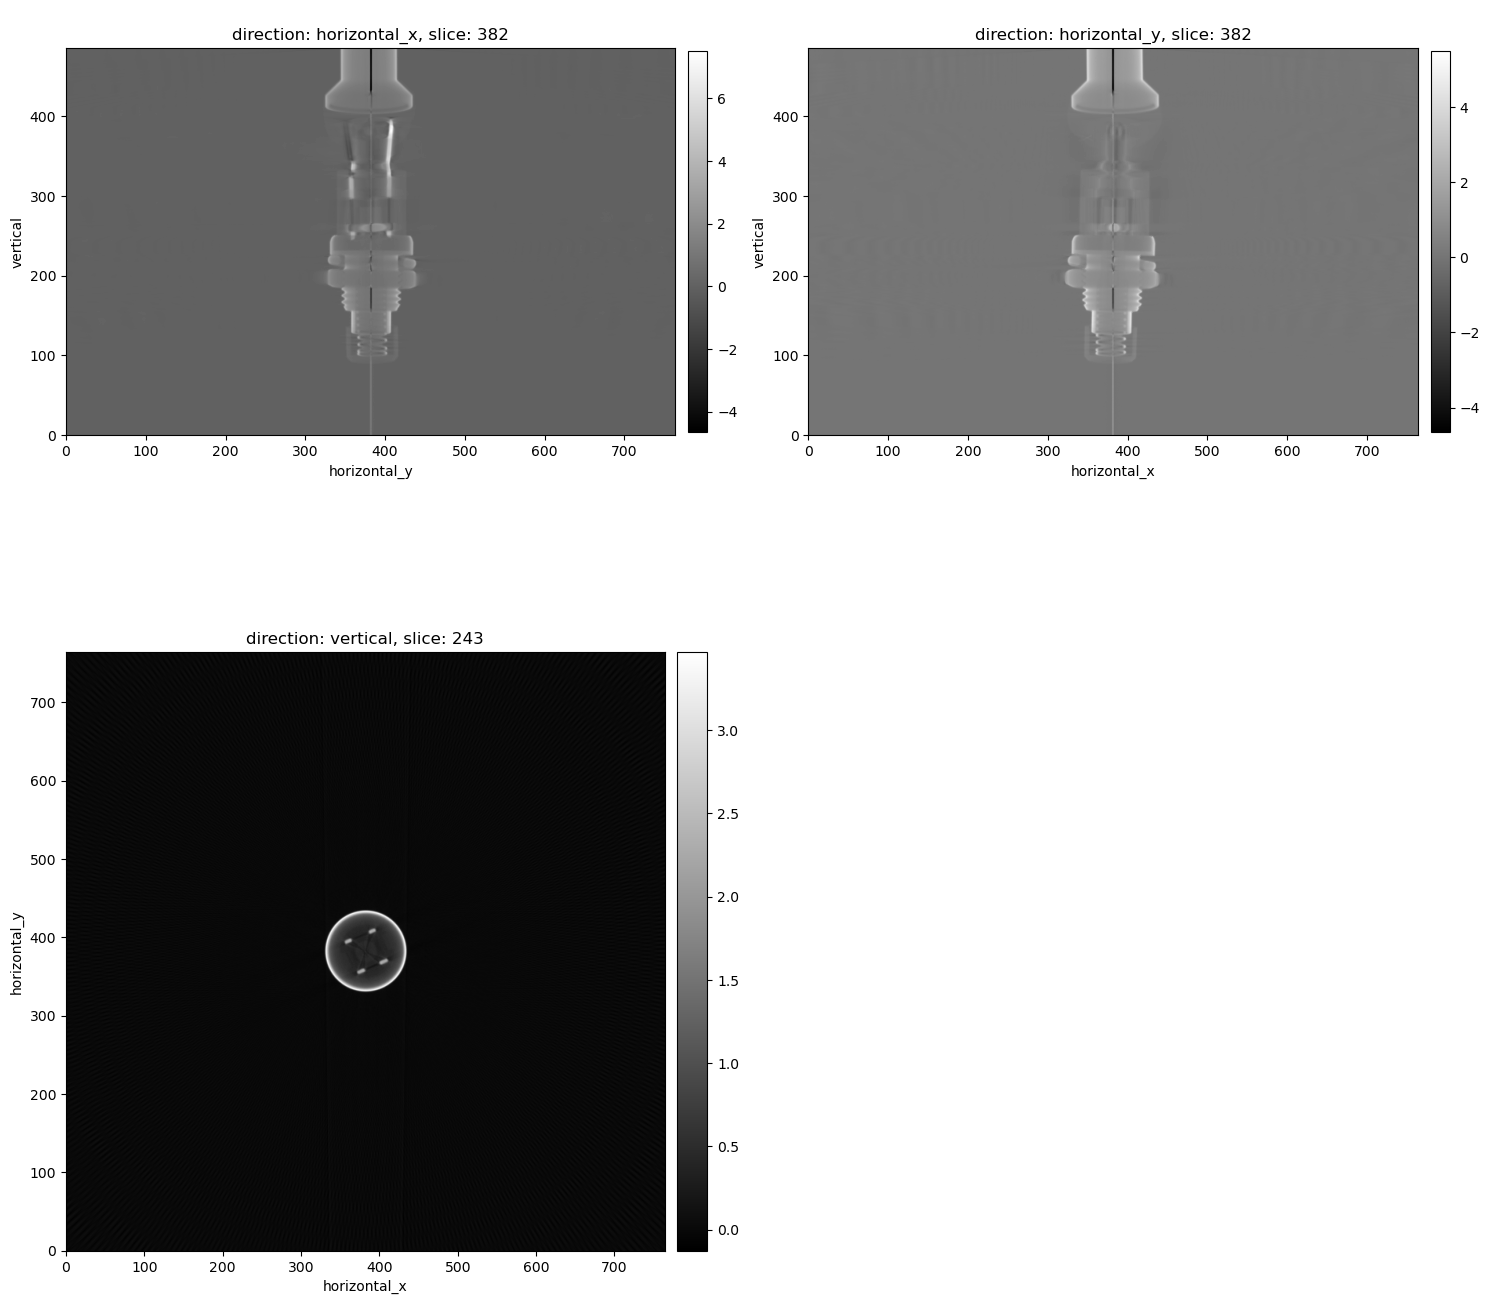

In [33]:
# Display data
show2D(recon, slice_list=[('horizontal_x', np.floor_divide(ig.shape[2],2)),('horizontal_y', np.floor_divide(ig.shape[1],2)), ('vertical', np.floor_divide(ig.shape[0],2))])

In [34]:
# Save data
subfolder = dataset_prefix
TIFFWriter(data=recon, file_name=os.path.join(datadir,subfolder,dataset_prefix),compression='uint8').write()